## Final Project Submission

Please fill out:
* Student name: Sung Hoon Bae
* Student pace: Full Time
* Scheduled project review date/time: 
* Instructor name: James Irving
* Blog post URL:


In [20]:
import pickle
def save_data(data, name):
    with open(name, 'wb') as f:
        pickle.dump(data, f)

def load_data(name):
    with open(name, 'rb') as f:
        return pickle.load(f)

# EDA

In [2]:
# Import necessary libraries needed to EDA.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

In /opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/anaconda3/envs/learn-env

In [3]:
# Importing Dataset
def import_data():
    X = pd.read_csv('datasets/Tanzanian/training_set.csv')
    y = pd.read_csv('datasets/Tanzanian/train_result.csv')
    return X, y
X, y = import_data()
# Converts functional wells into 1 and non-functional ones into 0.
# y['status_group'] = y['status_group'].apply(lambda x: 1 if x=='functional' else 0)

# Import the data and make sure it has loaded well
X.shape

(59400, 40)

In [4]:
def get_percent_retained(df):
    original_length = 59400
    print(f'Original Length: {original_length}')
    print(f'Current Length: {df.shape[0]}')
    print(f'Percent Retained: {round(df.shape[0]/original_length * 100, 2)}%')

## Feature Engineering Try #1


<AxesSubplot:>

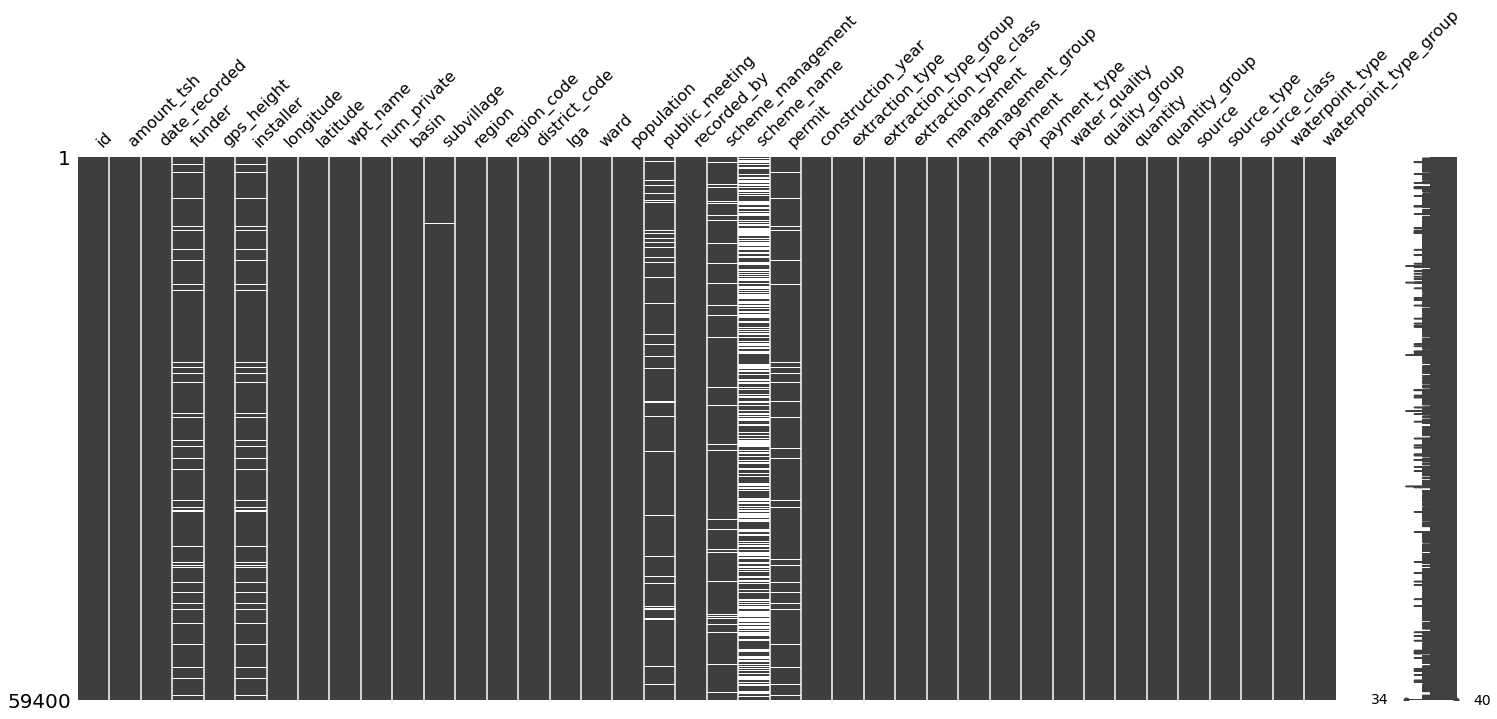

In [5]:
import missingno as ms
ms.matrix(X)

In [6]:
X.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group'],
      dtype='object')

### Columns to drop

In [7]:
cols_to_drop = ['amount_tsh',
 'num_private',
 'basin',
 'subvillage',
 'region',
 'lga',
 'ward',
 'recorded_by',
 'extraction_type_group',
 'extraction_type_class',
 'payment',
 'water_quality',
 'source_type',
 'quantity_group',
 'waterpoint_type',
 'scheme_name']

In [ ]:
X.drop(columns=cols_to_drop, inplace=True)

### Takes care of datetime

In [ ]:
X['date_recorded'] = pd.to_datetime(X['date_recorded'])
X['year_recorded'] = X['date_recorded'].apply(lambda x: x.year)
X['month_recorded'] = X['date_recorded'].apply(lambda x: x.month)
X.drop(columns=['date_recorded'], axis=1, inplace=True)

In [ ]:
X.head()

### wpt_name into a boolean column

In [ ]:
# 1 if a name exists and 0 if not.
X['wpt_name'] = X['wpt_name']!='none'

In [ ]:
X.isna().sum()

## Dropping missing rows

In [ ]:
# Dropping rows with missing values
df = pd.concat([X, y], axis=1)
df.head()

In [ ]:
# missing values
ms.matrix(df)

In [ ]:
df = drop_rows_na(df, 'public_meeting')
df = drop_rows_na(df, 'permit')

In [21]:
def drop_rows_na(df, col):
    indices = df[col].dropna().index
    return df.loc[indices,:]

In [ ]:
ms.matrix(df)

In [ ]:
get_percent_retained(df)

## Cat vs Num columns

In [ ]:
# Categorical Columns
cat_cols = X.select_dtypes('O').columns
# Numerical Columsn
num_cols = X.select_dtypes(include=['float64', 'int64']).columns

In [ ]:
cat_cols = list(cat_cols)
num_cols = list(num_cols)

In [ ]:
num_cols.remove('id')

In [ ]:
num_cols

# Vanilla Models

## Splitting Data

In [ ]:
from sklearn.metrics import accuracy_score, auc, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split

In [ ]:
X = df.drop(columns=['status_group'], axis=1)
y = df['status_group']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

## Setting pipeline

In [32]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn import set_config
set_config(display='diagram')

In [ ]:
pipe_cat = Pipeline(steps=[('imp', SimpleImputer(strategy='constant', fill_value='MISSING')),
                           ('encoder', OneHotEncoder(sparse=False, handle_unknown='ignore'))])

pipe_num = Pipeline(steps=[('imp', SimpleImputer(missing_values=0, strategy='median')),
                           ('scale', StandardScaler())])

In [ ]:
preprocessing = ColumnTransformer(transformers=[
    ('cat', pipe_cat, cat_cols),
    ('num', pipe_num, num_cols)
])
preprocessing

In [ ]:
X_train_tf = preprocessing.fit_transform(X_train)
X_test_tf = preprocessing.transform(X_test)

In [ ]:
feature_names = preprocessing.named_transformers_['cat'].\
                named_steps['encoder'].get_feature_names(cat_cols).tolist()
feature_names

features = feature_names+num_cols

In [ ]:
X_train_tf = pd.DataFrame(X_train_tf, columns = features)
X_test_tf = pd.DataFrame(X_test_tf, columns = features)

## Evaluating Classifier Model

In [ ]:
import sklearn.metrics as metrics

def evaluate_classification(model,X_test,y_test,classes=None,
                           normalize='true',cmap='Purples',label=''):
    """Accepts an sklearn-compatible classification model + test data 
    and displays several sklearn.metrics functions: 
    - classifciation_report
    - plot_confusion_matrix
    - plot_roc_curve
    """
     
    ## Get Predictions
    y_hat_test = model.predict(X_test)
    
    
    ## Classification Report / Scores 
    table_header = "[i] CLASSIFICATION REPORT"
    
    ## Add Label if given
    if len(label)>0:
        table_header += f" {label}"
        
    
    ## PRINT CLASSIFICATION REPORT
    dashes = '---'*20
    print(dashes,table_header,dashes,sep='\n')

    print(metrics.classification_report(y_test,y_hat_test,
                                    target_names=classes))
    
    report = metrics.classification_report(y_test,y_hat_test,
                                               target_names=classes,
                                          output_dict=True)
    print(dashes+"\n\n")
    
    

    ## MAKE FIGURE
    fig, axes = plt.subplots(figsize=(10,4),ncols=2)
    
    ## Plot Confusion Matrix 
    metrics.plot_confusion_matrix(model, X_test,y_test,
                                  display_labels=classes,
                                  normalize=normalize,
                                 cmap=cmap,ax=axes[0])
    axes[0].set(title='Confusion Matrix')
    
    ## Plot Roc Curve
#     roc_plot = metrics.plot_roc_curve(model, X_test, y_test,ax=axes[1])
#     axes[1].legend()
#     axes[1].plot([0,1],[0,1],ls=':')
#     axes[1].grid()
#     axes[1].set_title('Receiving Operator Characteristic (ROC) Curve') 
    fig.tight_layout()
    plt.show()
    
    return report #fig,axes

## Round 1 models

### Random Tree Model

In [10]:
from sklearn.ensemble import RandomForestClassifier
# rf = RandomForestClassifier()
# rf.fit(X_train_tf, y_train)

# evaluate_classification(rf, X_test_tf, y_test);

### Decision Tree

In [11]:
from sklearn.tree import DecisionTreeClassifier
# tree = DecisionTreeClassifier()
# tree.fit(X_train_tf, y_train)

# evaluate_classification(tree, X_test_tf, y_test);

### XGBoost classifier

In [12]:
temp_col_names = [f'x{i}' for i in range(len(X_train_tf.columns))]
X_train_tf.columns = temp_col_names
X_train_tf

NameError: name 'X_train_tf' is not defined

In [13]:
from xgboost import XGBClassifier
# xgb = XGBClassifier()
# xgb.fit(X_train_tf, y_train)

In [ ]:
X_test_tf.columns = temp_col_names_col_names
evaluate_classification(xgb, X_test_tf, y_test);

In [ ]:
X_train_tf.columns = features
X_test_tf.columns = features

### Adaboost classifier

In [14]:
from sklearn.ensemble import AdaBoostClassifier
# ab = AdaBoostClassifier()
# ab.fit(X_train_tf, y_train)

# evaluate_classification(ab, X_test_tf, y_test);

### KNN Classifier

In [15]:
from sklearn.neighbors import KNeighborsClassifier
# knn = KNeighborsClassifier()
# knn.fit(X_train_tf, y_train)

# evaluate_classification(ab, X_test_tf, y_test);

### SVM Classifier

In [16]:
import sklearn.svm as svm
# sv = svm.SVC()
# sv.fit(X_train_tf, y_train)

# evaluate_classification(sv, X_test_tf, y_test);

### Comparing all the models Round #1

In [ ]:
models_1 = [tree, rf, xgb, ab, knn, sv]
model_names_1 = ['Decision Tree', 
                 'Random Forest',
                 'XGBoost',
                 'AdaBoost',
                 'K Nearest Neighbor',
                 'Support Vector Machine']

In [ ]:
# saving the models
save_data(models_1, 'model_1')
# # loading the data
# models_1 = load_data('model_1')

In [ ]:
for model, name in zip(models_1, model_names_1):
    print('')
    print('-'*40)
    print(f'Feature Importance for {name}')
    print('-'*40)
    try:
        print(pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)[:15])
    except:
        pass
    

In [ ]:
df.columns

In [ ]:
cols_to_drop += ['id', 'funder', 'installer', 'scheme_management']

In [ ]:
df['status_group'].value_counts(normalize=True)


In [ ]:
df['funder'].nunique()

> 1. Drop installer and funder for they have more than 2000 unique values.
2. Drop rows with 0 lat and long


# Models Round 2

In [22]:
cols_to_drop=['amount_tsh',
 'num_private',
 'basin',
 'subvillage',
 'region',
 'lga',
 'ward',
 'recorded_by',
 'extraction_type_group',
 'extraction_type_class',
 'water_quality',
 'source_type',
 'quantity_group',
 'waterpoint_type',
 'scheme_name',
 'id']

## Dropping Different Additional Columns

In [23]:
def import_data(drop_cols=None):
    X = pd.read_csv('datasets/Tanzanian/training_set.csv')
    y = pd.read_csv('datasets/Tanzanian/train_result.csv')
    
    X['date_recorded'] = pd.to_datetime(X['date_recorded'])
    X['year_recorded'] = X['date_recorded'].apply(lambda x: x.year)
    X['month_recorded'] = X['date_recorded'].apply(lambda x: x.month)
    X.drop(columns=['date_recorded'], axis=1, inplace=True)
    
    # 1 if a name exists and 0 if not.
    X['wpt_name'] = X['wpt_name']!='none'
    
    if drop_cols != None:
        X.drop(columns=drop_cols, axis=1, inplace=True)
    
    df = pd.concat([X, y[['status_group']]], axis=1)
    
    cols = ['permit', 'public_meeting']
    for col in cols:
        df = drop_rows_na(df, col)
        df = df.reset_index().drop(columns='index')
    
    # get rid of rows with 0 lat and 0 long
    df.drop(df[(df['latitude']>-0.5)].index, inplace=True)
    df = df.reset_index().drop(columns='index')
    
    get_percent_retained(df)
    return df

In [24]:
# Import Data
df = import_data(cols_to_drop)

X = df.drop(columns='status_group', axis=1)
y = df[['status_group']]

Original Length: 59400
Current Length: 51827
Percent Retained: 87.25%


## Feature #1: percent nearby within 30km radius

In [25]:
import math
def get_distance(x, y):
    """
    x = [lat and long]
    y = array of lat and long
    """
    pi = np.pi
    R = 6371 # Average Earth radius in km
    
    # converts to radians
    lat1 = x[0]*pi/180 
    lat2 = y.iloc[:,0]*pi/180
    long1 = x[1]*pi/180
    long2 = y.iloc[:,1]*pi/180

    # finds delta angles
    del_lat = lat1 - lat2
    del_long = long1 - long2
        
    # Source: https://www.movable-type.co.uk/
    a = np.sin(del_lat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(del_long/2)**2
    c = 2*np.arctan(np.sqrt(a)/np.sqrt(1-a))
    d= R*c # distance in km
        
    return d

In [26]:
print(X.shape, y.shape)

(51827, 25) (51827, 1)


In [ ]:
perc_func_near = []
perc_non_func_near = []
perc_repair_near = []

for index, row in X.iterrows():
#     print(index, row['latitude'], row['longitude'])
    wp = [row['latitude'], row['longitude']]
    wps = X[['latitude', 'longitude']].copy()
    
    d = get_distance(wp, wps)
    
    distance = 30
    indices = X[d < distance].index
    

    perc_func = round(np.sum(y.iloc[indices, :] == 'functional')/len(indices)*100, 2)
    perc_non_func = round(np.sum(y.iloc[indices, :] == 'non functional')/len(indices)*100, 2)
    perc_repair_func = round(np.sum(y.iloc[indices, :] == 'functional needs repair')/len(indices)*100, 2)
    
    perc_func_near.append(perc_func[0])
    perc_non_func_near.append(perc_non_func[0])
    perc_repair_near.append(perc_repair_func[0])
    



In [ ]:
df['perc_func_nearby'] = perc_func_near
df['perc_on_func_nearby'] = perc_non_func_near
df['perc_repair_nearby'] = perc_repair_near

In [ ]:
df.drop(columns='id', axis=1, inplace=True)

## Feature #2 Extraction Type

In [ ]:
df['extraction_type'].value_counts(normalize=True)

In [ ]:
df['extraction_type'].unique()

In [ ]:
extraction_dict = {'nira/tanira':'nira', 'swn 80':'other', 
                   'other - rope pump': 'other', 'other - swn 81': 'other',
                   'other - play pump': 'other', 'other - mkulima/shinyanga':'other',
                   'windmill': 'other', 'cemo':'other', 'climax':'other',
                   'walimi':'other', 'india mark iii':'other'}

In [ ]:
# replaces insignificant extractor types as 'other'
df['extraction_type'] = df['extraction_type'].apply(lambda x: extraction_dict[x] if x in extraction_dict.keys() else x)

## Feature #3: installer and funder

In [ ]:
# makes a dictionary that has percent func/non func/repair for each installer
sample = df[['installer', 'status_group']].copy()

sample_dummies = pd.get_dummies(sample, columns=['status_group'])

a = sample_dummies.groupby('installer').sum()

a['total'] = a.sum(axis=1)

a['perc_func'] = a['status_group_functional']/a['total']
a['perc_repair'] = a['status_group_functional needs repair']/a['total']
a['perc_non_func'] = a['status_group_non functional']/a['total']

a = a[['perc_func', 'perc_repair', 'perc_non_func']].reset_index()

installer_dict = {}
for index, row in a.iterrows():
    installer_dict[row['installer']] = [row['perc_func'], row['perc_repair'], row['perc_non_func']]

In [ ]:
# makes a dictionary that has percent func/non func/repair for each funder
sample = df[['funder', 'status_group']].copy()

sample_dummies = pd.get_dummies(sample, columns=['status_group'])

a = sample_dummies.groupby('funder').sum()

a['total'] = a.sum(axis=1)

a['perc_func'] = a['status_group_functional']/a['total']
a['perc_repair'] = a['status_group_functional needs repair']/a['total']
a['perc_non_func'] = a['status_group_non functional']/a['total']
a = a[['perc_func', 'perc_repair', 'perc_non_func']].reset_index()

funder_dict = {}
for index, row in a.iterrows():
    funder_dict[row['funder']] = [row['perc_func'], row['perc_repair'], row['perc_non_func']]

In [ ]:
df['funder_perc_func'] = df['funder'].apply(lambda x: funder_dict[x][0] if x in funder_dict.keys() else np.NaN)
df['funder_perc_repair'] = df['funder'].apply(lambda x: funder_dict[x][1] if x in funder_dict.keys() else np.NaN)
df['funder_perc_non_func'] = df['funder'].apply(lambda x: funder_dict[x][2] if x in funder_dict.keys() else np.NaN)

In [ ]:
df['installer_perc_func'] = df['installer'].apply(lambda x: installer_dict[x][0] if x in installer_dict.keys() else np.NaN)
df['installer_perc_repair'] = df['installer'].apply(lambda x: installer_dict[x][1] if x in installer_dict.keys() else np.NaN)
df['installer_perc_non_func'] = df['installer'].apply(lambda x: installer_dict[x][2] if x in installer_dict.keys() else np.NaN)

In [ ]:
df.drop(columns=['funder', 'installer'], inplace=True)

In [ ]:
df

In [ ]:
# df = pd.concat([df, df_1[['perc_func_nearby','perc_on_func_nearby','perc_repair_nearby']]], axis=1)

In [35]:
cat_cols = list(df.drop(columns='status_group', axis=1).select_dtypes('O').columns)
cat_cols.append('wpt_name')
num_cols = list(df.select_dtypes(['int64', 'float64']).columns)

In [ ]:
cat_cols

In [ ]:
num_cols

In [ ]:
print('Number of columns in cat and num cols: ',len(cat_cols) + len(num_cols))
print('Number of columns: ', df.shape[1]-1)

In [27]:
# Saving dataframe until now
# save_data(df, 'dataframe_model_2')
# loading datafrom for model #2
df = load_data('dataframe_model_2')

## Splitting

In [29]:
from sklearn.model_selection import train_test_split
# df.drop(columns='scheme_management', axis=1, inplace=True)
X = df.drop(columns='status_group', axis=1)
y = df['status_group']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

## Preprocessing

In [33]:
from sklearn.pipeline import Pipeline
pipe_cat = Pipeline(steps=[('imp', SimpleImputer(strategy='constant', fill_value='MISSING')),
                           ('encoder', OneHotEncoder(sparse=False, handle_unknown='ignore'))])

pipe_num = Pipeline(steps=[('imp', SimpleImputer(strategy='median')),
                           ('scale', StandardScaler())])

In [36]:
preprocessing2 = ColumnTransformer(transformers=[('num', pipe_num, num_cols),
                                                 ('cat', pipe_cat, cat_cols)])
preprocessing2

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imp',
                                                  SimpleImputer(strategy='median')),
                                                 ('scale', StandardScaler())]),
                                 ['gps_height', 'longitude', 'latitude',
                                  'region_code', 'district_code', 'population',
                                  'construction_year', 'year_recorded',
                                  'month_recorded', 'funder_perc_func',
                                  'funder_perc_repair', 'funder_perc_non_func',
                                  'installer_perc_func',
                                  'instal...
                                 Pipeline(steps=[('imp',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['public_meeting', 'scheme_management',
                                  'permit', 'extraction_type', 'management',
                                  'management_group', 'payment', 'payment_type',
                                  'quality_group', 'quantity', 'source',
                                  'source_class', 'waterpoint_type_group',
                                  'wpt_name'])])

In [37]:
X_train_tf = preprocessing2.fit_transform(X_train)

In [38]:
feature_names = preprocessing2.named_transformers_['cat'].\
                named_steps['encoder'].get_feature_names(cat_cols).tolist()
feature_names

features = num_cols + feature_names

X_train_tf = pd.DataFrame(X_train_tf, columns = features)

In [39]:
X_test_tf = preprocessing2.transform(X_test)
X_test_tf = pd.DataFrame(X_test_tf, columns = features)

## SMOTENC

In [40]:
import six
import sys
sys.modules['sklearn.externals.six'] = six

from imblearn.over_sampling import SMOTE

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [41]:
y_train.value_counts(normalize=True)

functional                 0.550223
non functional             0.381388
functional needs repair    0.068389
Name: status_group, dtype: float64

In [ ]:
# # get the number of columns that are categorical
# cat_cols_nums = [k for k, x in enumerate(df.columns) if x in cat_cols]
# cat_cols_nums

In [42]:
X_train_smote_tf, y_train_smote = SMOTE().fit_resample(X_train_tf, y_train)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [43]:
y_train.value_counts(normalize=True)

functional                 0.550223
non functional             0.381388
functional needs repair    0.068389
Name: status_group, dtype: float64

In [44]:
pd.Series(y_train_smote).value_counts(normalize=True)

functional                 0.333333
non functional             0.333333
functional needs repair    0.333333
dtype: float64

In [45]:
X_train_smote_tf = pd.DataFrame(X_train_smote_tf, columns = X_train_tf.columns)
X_train_smote_tf

,gps_height,longitude,latitude,region_code,district_code,population,construction_year,year_recorded,month_recorded,funder_perc_func,...,source_class_surface,source_class_unknown,waterpoint_type_group_cattle trough,waterpoint_type_group_communal standpipe,waterpoint_type_group_dam,waterpoint_type_group_hand pump,waterpoint_type_group_improved spring,waterpoint_type_group_other,wpt_name_False,wpt_name_True
0,1.435816,-0.256214,-1.376048,-0.230433,-0.088365,-0.151195,0.694132,-0.900086,-0.436093,1.621485,...,0.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.000000,1.0,0.0
1,1.800097,-1.316811,-0.795271,-0.010513,-0.188039,0.711401,0.685602,1.184856,-1.113344,-1.053972,...,1.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.000000,0.0,1.0
2,0.960667,-0.388206,1.085076,0.099447,-0.487060,0.711401,0.703729,1.184856,-0.774718,-0.049136,...,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.000000,0.0,1.0
3,0.543112,0.752072,0.947126,-0.670274,-0.088365,-0.364043,0.701596,1.184856,0.579783,1.656123,...,0.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.000000,0.0,1.0
4,-0.980243,-0.998025,-1.145203,-0.175453,0.011309,-0.408853,-1.429857,-0.900086,0.918409,0.056705,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59878,-0.995488,1.375587,-0.229498,-0.505334,-0.487060,-0.371295,0.699024,-0.900086,-0.774718,1.437590,...,1.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.000000,0.0,1.0
59879,-0.429546,0.851799,-0.141605,-0.560314,0.011309,-0.406613,0.708092,-0.900086,1.257034,0.262088,...,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,1.000000,0.0,1.0
59880,-0.980243,-0.776839,-0.550672,-0.175453,-0.487060,-0.408853,-1.429857,-0.900086,-0.097468,-0.684673,...,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.000000,0.0,1.0
59881,1.359977,-1.524502,-0.620041,-0.010513,-0.287712,-0.406613,0.690934,-0.900086,0.918409,-0.790540,...,0.0,0.0,0.0,0.0,0.0,0.575308,0.0,0.424692,0.0,1.0


## Modeling

### Models

In [46]:
def create_models(X_train, y_train, rf=True, tree=True, xgb=True, ab=True, knn=True, sv=True):
    models = []
    model_names = []
    if rf:
        rf = RandomForestClassifier()
        rf.fit(X_train, y_train)
        models.append(rf)
        model_names.append('Random Forest')
    
    if tree:
        tree = DecisionTreeClassifier()
        tree.fit(X_train, y_train)
        models.append(tree)
        model_names.append('Decision Tree')
    
    if xgb:
        xgb = XGBClassifier()
        xgb.fit(X_train, y_train)
        models.append(xgb)
        model_names.append('XGBoost')
    
    if ab:
        ab = AdaBoostClassifier()
        ab.fit(X_train, y_train)
        models.append(ab)
        model_names.append('AdaBoost')
    
    if knn:
        knn = KNeighborsClassifier()
        knn.fit(X_train, y_train)
        models.append(knn)
        model_names.append('K-Nearest Neighbor')
    
#     if sv:
#         sv = svm.SVC()
#         sv.fit(X_train, y_train)
#         models.append(sv)
#         model_names.append('Support Vector Machine')
    
    
    return models, model_names

In [47]:
models = create_models(X_train_smote_tf, y_train_smote, sv=False)

models_2, model_names_2 = models

### Evaluating Models

------------------------------------------------------------
Train Accuracy :  1.0
Test Accuracy :  0.79
------------------------------------------------------------
------------------------------------------------------------
[i] CLASSIFICATION REPORT Random Forest
------------------------------------------------------------
                         precision    recall  f1-score   support

             functional       0.83      0.84      0.83      8490
functional needs repair       0.38      0.45      0.41      1019
         non functional       0.83      0.79      0.81      6040

               accuracy                           0.79     15549
              macro avg       0.68      0.69      0.69     15549
           weighted avg       0.80      0.79      0.80     15549

------------------------------------------------------------




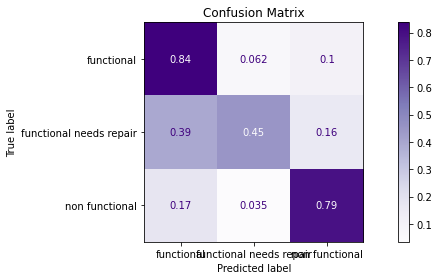

------------------------------------------------------------
Train Accuracy :  1.0
Test Accuracy :  0.75
------------------------------------------------------------
------------------------------------------------------------
[i] CLASSIFICATION REPORT Decision Tree
------------------------------------------------------------
                         precision    recall  f1-score   support

             functional       0.81      0.78      0.80      8490
functional needs repair       0.31      0.41      0.35      1019
         non functional       0.76      0.77      0.76      6040

               accuracy                           0.75     15549
              macro avg       0.63      0.65      0.64     15549
           weighted avg       0.76      0.75      0.75     15549

------------------------------------------------------------




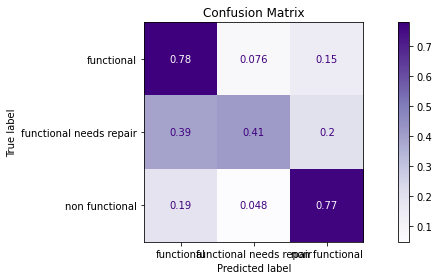

------------------------------------------------------------
Train Accuracy :  0.75
Test Accuracy :  0.69
------------------------------------------------------------
------------------------------------------------------------
[i] CLASSIFICATION REPORT XGBoost
------------------------------------------------------------
                         precision    recall  f1-score   support

             functional       0.82      0.70      0.76      8490
functional needs repair       0.22      0.72      0.34      1019
         non functional       0.81      0.68      0.74      6040

               accuracy                           0.69     15549
              macro avg       0.62      0.70      0.61     15549
           weighted avg       0.78      0.69      0.72     15549

------------------------------------------------------------




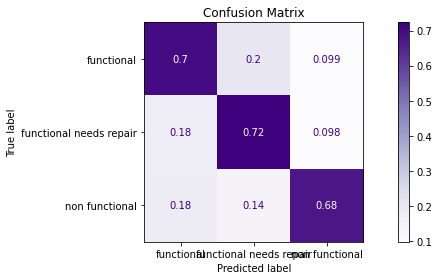

------------------------------------------------------------
Train Accuracy :  0.71
Test Accuracy :  0.67
------------------------------------------------------------
------------------------------------------------------------
[i] CLASSIFICATION REPORT AdaBoost
------------------------------------------------------------
                         precision    recall  f1-score   support

             functional       0.80      0.68      0.74      8490
functional needs repair       0.22      0.69      0.33      1019
         non functional       0.78      0.66      0.72      6040

               accuracy                           0.67     15549
              macro avg       0.60      0.68      0.59     15549
           weighted avg       0.76      0.67      0.70     15549

------------------------------------------------------------




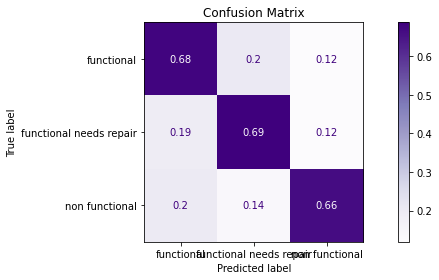

------------------------------------------------------------
Train Accuracy :  0.88
Test Accuracy :  0.73
------------------------------------------------------------
------------------------------------------------------------
[i] CLASSIFICATION REPORT K-Nearest Neighbor
------------------------------------------------------------
                         precision    recall  f1-score   support

             functional       0.83      0.75      0.79      8490
functional needs repair       0.27      0.58      0.37      1019
         non functional       0.79      0.74      0.76      6040

               accuracy                           0.73     15549
              macro avg       0.63      0.69      0.64     15549
           weighted avg       0.77      0.73      0.75     15549

------------------------------------------------------------




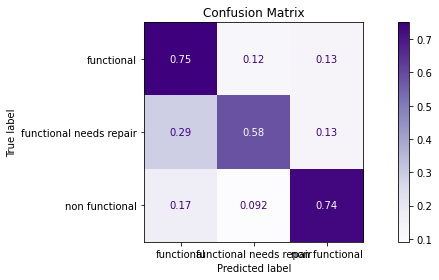

In [51]:
model_reports = []
for model, name in zip(models_2, model_names_2):
    model_report = evaluate_clf_model(model, X_train_smote_tf, y_train_smote,
                       X_test_tf, y_test,
                       label=name);
    model_reports.append(model_report)

In [52]:
for model, name in zip(models_2, model_names_2):
    print('')
    print('-'*40)
    print(f'Feature Importance for {name}')
    print('-'*40)
    try:
        print(pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)[:15])
    except:
        pass
    


----------------------------------------
Feature Importance for Random Forest
----------------------------------------
perc_repair_nearby         0.088571
perc_on_func_nearby        0.058821
longitude                  0.058435
perc_func_nearby           0.057878
latitude                   0.055887
quantity_dry               0.050827
funder_perc_repair         0.044861
installer_perc_repair      0.040504
installer_perc_non_func    0.036766
installer_perc_func        0.036516
funder_perc_func           0.035708
gps_height                 0.033858
funder_perc_non_func       0.032059
population                 0.028591
construction_year          0.025907
dtype: float64

----------------------------------------
Feature Importance for Decision Tree
----------------------------------------
perc_repair_nearby             0.150511
quantity_dry                   0.086104
longitude                      0.074189
latitude                       0.059986
funder_perc_func               0.055531
insta

In [50]:
import sklearn.metrics as metrics

def evaluate_clf_model(model,X_train, y_train, X_test,y_test,classes=None,
                           normalize='true',cmap='Purples', label=''):
    """Accepts an sklearn-compatible classification model + test data 
    and displays several sklearn.metrics functions: 
    - classifciation_report
    - plot_confusion_matrix
    - 
    - plot_roc_curve
    """
     
    ## Get Predictions
    y_hat_train = model.predict(X_train)
    y_hat_test = model.predict(X_test)
    
    print('---'*20)
    print('Train Accuracy : ', round(metrics.accuracy_score(y_train, y_hat_train),2))
    print('Test Accuracy : ', round(metrics.accuracy_score(y_test, y_hat_test),2))
    print('---'*20)
    ## Classification Report / Scores 
    table_header = "[i] CLASSIFICATION REPORT"
    
    ## Add Label if given
    if len(label)>0:
        table_header += f" {label}"
        
    
    ## PRINT CLASSIFICATION REPORT
    dashes = '---'*20
    print(dashes,table_header,dashes,sep='\n')

    print(metrics.classification_report(y_test,y_hat_test,
                                    target_names=classes))
    
    report = metrics.classification_report(y_test,y_hat_test,
                                               target_names=classes,
                                          output_dict=True)
    print(dashes+"\n\n")
    
    

    ## MAKE FIGURE
    fig, axes = plt.subplots(figsize=(10,4))#,ncols=2)
    
    ## Plot Confusion Matrix 
    metrics.plot_confusion_matrix(model, X_test,y_test,
                                  display_labels=classes,
                                  normalize=normalize,
                                 cmap=cmap,ax=axes)
    axes.set(title='Confusion Matrix')
    
    ## Plot Roc Curve
#     roc_plot = metrics.plot_roc_curve(model, X_test, y_test,ax=axes[1])
#     axes[1].legend()
#     axes[1].plot([0,1],[0,1],ls=':')
#     axes[1].grid()
#     axes[1].set_title('Receiving Operator Characteristic (ROC) Curve') 
    fig.tight_layout()
    plt.show()
    
    return report, fig, axes

### hyperparameter tuning

In [ ]:
from sklearn.model_selection import GridSearchCV
rf = RandomForestClassifier()
param_rf = dict(criterion=['gini'],
                 n_estimators=[200, 350, 500],
                 class_weight=[None, 'balanced'],
                 max_depth = [10, 15, 20, None],
                 min_samples_split=[0.001, 0.005, 0.01])
grid_rf = GridSearchCV(rf, param_grid=param_rf, cv=3, n_jobs=-1, scoring='recall_macro')

grid_rf.fit(X_train_tf, y_train)

In [79]:
grid_rf.best_params_

{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 15,
 'min_samples_split': 0.001,
 'n_estimators': 350}

In [80]:
model_rf_3 = grid_rf.best_estimator_

------------------------------------------------------------
Train Accuracy :  0.78
Test Accuracy :  0.74
------------------------------------------------------------
------------------------------------------------------------
[i] CLASSIFICATION REPORT
------------------------------------------------------------
                         precision    recall  f1-score   support

             functional       0.85      0.74      0.79      8490
functional needs repair       0.27      0.71      0.39      1019
         non functional       0.82      0.74      0.78      6040

               accuracy                           0.74     15549
              macro avg       0.65      0.73      0.65     15549
           weighted avg       0.80      0.74      0.76     15549

------------------------------------------------------------




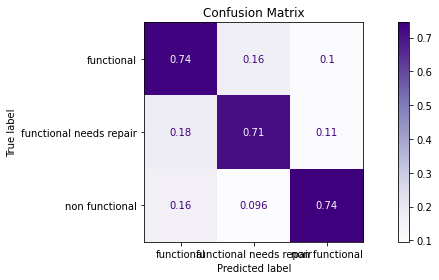

In [81]:
evaluate_clf_model(model_rf_3, X_train_tf, y_train, X_test_tf, y_test);

In [76]:
models_2[0].get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [ ]:
# from sklearn.model_selection import GridSearchCV
xgb = XGBClassifier()
param_xgb = dict(n_estimators=[250],
                 learning_rate=[0.1],
                 max_depth = [5],
                 subsample=[0.8],
                 min_child_weight=[0.8],
                 n_jobs=-1)
grid_xgb = GridSearchCV(xgb, param_grid=param_rf, cv=3, n_jobs=-1, scoring='recall_macro')

grid_xgb.fit(X_train_tf, y_train)

In [ ]:
xgb = XGBClassifier()
param_xgb = dict(n_estimators=[100, 200, 300],
                 learning_rate=[0.01, 0.05, 0.1],
                 max_depth = [1, 3],
                 gamma=[0.01, 0.05, 0.1])
grid_xgb_smote = GridSearchCV(xgb, param_grid=param_rf, cv=3, n_jobs=-1, scoring='recall_macro')

grid_xgb_smote.fit(X_train_smote_tf, y_train_smote)

In [ ]:
# from sklearn.model_selection import GridSearchCV
ab = AdaBoostClassifier()
param_ab = dict(n_estimators=[50, 10, 150],
                 learning_rate=[0.01, 0.05, 0.1])
grid_ab = GridSearchCV(ab, param_grid=param_rf, cv=3, n_jobs=-1, scoring='recall_macro')

grid_ab.fit(X_train_tf, y_train)

In [ ]:
rf = RandomForestClassifier()
param_rf = dict(criterion=['gini'],
                 n_estimators=[200, 350, 500],
                 class_weight=[None, 'balanced'],
                 max_depth = [10, 15, 20, None],
                 min_samples_split=[0.001, 0.005, 0.01])
grid_rf_smote = GridSearchCV(rf, param_grid=param_rf, cv=3, n_jobs=-1, scoring='recall_macro')

grid_rf_smote.fit(X_train_smote_tf, y_train_smote)

In [ ]:
# from sklearn.model_selection import GridSearchCV
ab = AdaBoostClassifier()
param_ab = dict(n_estimators=[50, 10, 150],
                 learning_rate=[0.01, 0.05, 0.1])
grid_ab_smote = GridSearchCV(ab, param_grid=param_rf, cv=3, n_jobs=-1, scoring='recall_macro')

grid_ab_smote.fit(X_train_smote_tf, y_train_smote)

# Introduction

In [ ]:
with open('datasets/Tanzanian/TZ_state_1.geojson', 'r') as f:
    tz_states = json.load(f)

In [ ]:
state_id_map = {}
for feature in tz_states['features']:
    feature['id'] = feature['properties']['ID_1']
    state_id_map[feature['properties']['NAME_1']] = feature['id']
state_id_map['Dar es Salaam'] = 2
state_id_map.pop('Dar-Es-Salaam')

In [ ]:
state_id_map

In [ ]:
df['region_id'] = df['region'].apply(lambda x: state_id_map[x])

In [ ]:
df.keys()

In [ ]:
sns.scatterplot(x='construction_year', y='status_group', data=df)

In [ ]:
a = df[df['region']=='Kaskazini-Pemba']
a.shape

In [ ]:
df['source_class'].isna().sum()

In [ ]:
df_region = pd.DataFrame(dict(id=list(state_id_map.values()),region = list(state_id_map.keys())))
df_region

In [ ]:
total_nums = []
total_func = []
total_repair = []
total_non_func = []

main_source = []
main_source_perc = []

quantity = []
quantity_perc = []

for region in df_region['region']:
    df_copy = df[df['region']==region].copy()
    if df_copy.shape[0] != 0:
        total_num = df_copy.shape[0]
        # Total number of wells installed in the region
        total_nums.append(total_num)

        # Total number of wells that are functions, non functional, and needs repair
        total_func.append((df_copy['status_group'] == 'functional').sum())
        total_non_func.append((df_copy['status_group'] == 'non functional').sum())
        total_repair.append((df_copy['status_group'] == 'functional needs repair').sum())

        # main water source
        try:
            main_source.append(df_copy['source_class'].value_counts(normalize=True).index[0])
            main_source_perc.append(df_copy['source_class'].value_counts(normalize=True)[0])
        except:
            print(region)

        # water quantity
        quantity.append(df_copy['quantity'].value_counts(normalize=True).index[0])
        quantity_perc.append(df_copy['quantity'].value_counts(normalize=True)[0])
    else:
        total_nums.append(0)
        total_func.append(0)
        total_non_func.append(0)
        total_repair.append(0)
        
        main_source.append(0)
        main_source_perc.append(0)
        
        quantity.append(0)
        quantity_perc.append(0)

        

In [ ]:
df_region['total_nums'] = total_nums
df_region['total_func'] = total_func
df_region['total_repair'] = total_repair
df_region['total_non_func'] = total_non_func

df_region['main_source'] = main_source
df_region['main_source_perc'] = main_source_perc

df_region['quantity'] = quantity
df_region['quantity_perc'] = quantity_perc

In [ ]:
df_region['func_perc']=round(df_region['total_func']/df_region['total_nums']*100,2)
df_region['non_func_perc']=round(df_region['total_non_func']/df_region['total_nums']*100,2)
df_region['repair_perc']=round(df_region['total_repair']/df_region['total_nums']*100,2)


In [ ]:
df_region.dropna()

In [ ]:
import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'chrome'

In [ ]:
px.choropleth(df_region, locations='id', 
              geojson=tz_states, 
              hover_name = 'region',
              hover_data = ['func_perc', 'non_func_perc', 'repair_perc'],
              color='total_nums',
              scope='africa')

## Testing